In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [3]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Gulliver Corpus**

In [8]:
fileGulliver = open("gulliver.txt", "r")
gulliver = fileGulliver.read()
print(gulliver[:1000])
new_gulliver = ""
for char in gulliver:
    if char in ['$', '%', '&', 'æ', 'œ', '–', '—', '‘', '’', '“', '”', '•', '™']:
        continue
    new_gulliver += char.lower()

characters = sorted(list(set(new_gulliver)))
print(len(new_gulliver))
print(len(characters))
print(characters)

PART I. A VOYAGE TO LILLIPUT.


CHAPTER I.

The author gives some account of himself and family. His first
inducements to travel. He is shipwrecked, and swims for his life, gets
safe on shore in the country of Lilliput; is made a prisoner, and
carried up the country.


My father had a small estate in Nottinghamshire; I was the third of
five sons. He sent me to Emanuel College in Cambridge at fourteen years
old, where I resided three years, and applied myself close to my
studies; but the charge of maintaining me, although I had a very scanty
allowance, being too great for a narrow fortune, I was bound apprentice
to Mr. James Bates, an eminent surgeon in London, with whom I continued
four years. My father now and then sending me small sums of money, I
laid them out in learning navigation, and other parts of the
mathematics, useful to those who intend to travel, as I always believed
it would be, some time or other, my fortune to do. When I left Mr.
Bates, I went down to my father: where, 

In [9]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["+"] = 0 ## Pad Character
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '+',
 1: '\n',
 2: ' ',
 3: '!',
 4: "'",
 5: '(',
 6: ')',
 7: '*',
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '?',
 25: '[',
 26: ']',
 27: '_',
 28: 'a',
 29: 'b',
 30: 'c',
 31: 'd',
 32: 'e',
 33: 'f',
 34: 'g',
 35: 'h',
 36: 'i',
 37: 'j',
 38: 'k',
 39: 'l',
 40: 'm',
 41: 'n',
 42: 'o',
 43: 'p',
 44: 'q',
 45: 'r',
 46: 's',
 47: 't',
 48: 'u',
 49: 'v',
 50: 'w',
 51: 'x',
 52: 'y',
 53: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

![](./media/MLPToken.svg)

In [10]:
block_size = 20
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_gulliver)):
  ix = stoi[new_gulliver[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [11]:
X.shape, Y.shape

(torch.Size([588307, 20]), torch.Size([588307]))

In [12]:
# Embedding layer for the context
emb_dim = 15
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [13]:
emb.weight.shape

torch.Size([54, 15])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

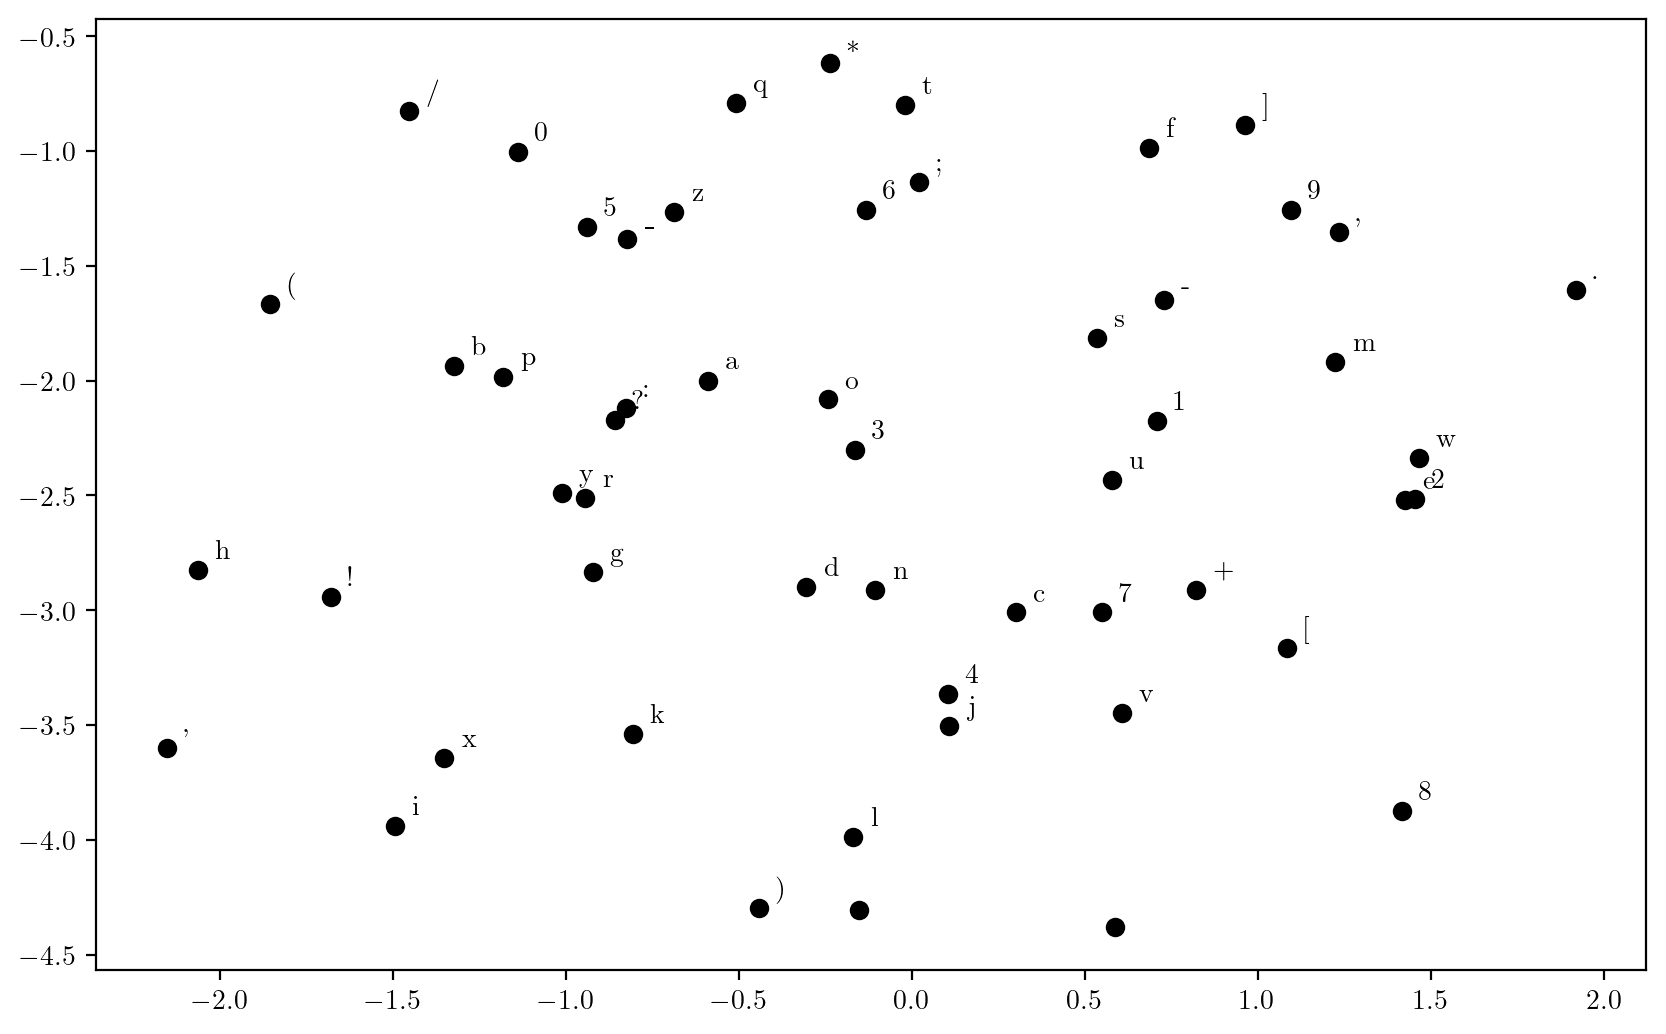

In [14]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax = None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [15]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size1, hidden_size2):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size1)
    self.lin2 = nn.Linear(hidden_size1, hidden_size2)
    self.lin3 = nn.Linear(hidden_size2, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = torch.tanh(self.lin2(x))
    x = self.lin3(x)
    return x

In [16]:
model = NextChar(block_size, len(stoi), emb_dim, 100, 75).to(device)
model = torch.compile(model)

In [17]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([54, 15])
_orig_mod.lin1.weight torch.Size([100, 300])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([75, 100])
_orig_mod.lin2.bias torch.Size([75])
_orig_mod.lin3.weight torch.Size([54, 75])
_orig_mod.lin3.bias torch.Size([54])


## Generating names from untrained model

In [19]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(4200)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text

my_str = generate_text(model, itos, stoi, block_size, 1000, "this is ")
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

this is g8lape!96(*(/lg2us)a8[
_p i2jn)xh,rrlkv5?ar/w;a/;q4ii'/[)q6w_w9gn82?*7twdt.[s_73oskyf;st;l4rsf5azl208(]v*)k(d8:_qqivi-g4]83-orj8]31?
 -*-k6y;ru8sibd.(t:_5viu,a;oh202d
?b/yv2q+9izk;q?a-):s5hpnc4w?g76c 7l*1 _uc*ea)bey4 z.z8q8/;oqt,f;6[gsr/( _hrh,]j(/,u'+dxr*bj;2[(v+ngc0x/ur5!295m/;k8-!.mxm[k7al!wads;idv7?/7'+pn1!uqzk:soj!:v8.c+gw9]4p
j:/n+!_mbulod w2vnqq5_7sg8kt/+pw32l0j7tc:jp
cn/4tzt?a8sc+fmrf!u;u/4,]2o,6*fhz-sk;jwxbi9poyc75.lno'i6]n0]?o 5m/acqx, k7+jie[q01('rz5n1+
b640.1wcx--,7,h2]4iov+*!sx[aj5rh,odnn5ucod:kl6 
t2qkr!nq[qrn0)b+h7b96
ur2--oqpws45b?fu)3*o2t][ lxujxe_h0v_wuy;?hhi]oy;o
t]ngr85x3'lo/*3i3gc?//-ckb3q?!u.aht,j2+]![*w?725?;z(,nko.
4 /y.m'ylw:3!yk07z+ tzw+k4_mx',8b-q;wb+-*r(fo t_v!w _();s1 xv69;nb;js;s6gx1:xx_;*7nyy ihs7jk 0vc:*[_+:
1xsw]nf;'+acg.boupg4lq+3h:'qk725!0.q.[?akq
y19_w52v8xbiq?c9;e.ky48'xq37nf2uh2rm)tg5zpb4+!ugq_4/o6j)rrhf:pbpd)].;3f634tzk?alg,v *4vzx.h.h,/[j]o c/+zd91;
+v0.qn2n
jh+) wxl.h:mby g8 -9xt3be9i*2tj-ru]-kr([
'i1'ooo!78pekbu2 9/32[t8'qu_dow 8f9toqx8

## Model Training

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 100
for epoch in range(10000):
  total_loss = 0
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred.view(-1, len(stoi)), y.view(-1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  if epoch % print_every == 0:
      average_loss = total_loss / (X.shape[0] / batch_size)
      print(f"Epoch {epoch}, Loss: {average_loss}")

Epoch 0, Loss: 2.3500139904234736
Epoch 100, Loss: 1.5366284913345625
Epoch 200, Loss: 1.5229149207824848
Epoch 300, Loss: 1.5201194115062373
Epoch 400, Loss: 1.514727689509102
Epoch 500, Loss: 1.512780083025848
Epoch 600, Loss: 1.5105230727550092
Epoch 700, Loss: 1.5072835614990876
Epoch 800, Loss: 1.5063379297501134
Epoch 900, Loss: 1.5048460752302264
Epoch 1000, Loss: 1.504239639291486


KeyboardInterrupt: 

## **Saving the model**

In [21]:
torch.save(model.state_dict(), "modelGulliver20_15.pth")

In [22]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[ 3.3029e-02, -6.7914e-01, -1.0795e-01,  1.1012e+00,  1.6284e-01,
                        3.4408e-01, -4.0317e-01, -1.4394e-01, -1.1969e+00,  2.1110e-01,
                       -1.2381e+00,  5.9811e-02, -3.6007e-01, -1.0570e+00,  1.2542e+00],
                      [-1.3331e-01, -9.0728e-02,  6.1493e-03, -1.5620e-02, -1.9301e-01,
                        5.1472e-02,  9.9306e-02, -8.1923e-02, -3.2375e-02,  9.7532e-02,
                       -2.0574e+00, -1.2393e-01, -6.2698e-02, -1.8381e-03,  5.1029e-01],
                      [-3.0902e-02, -2.4505e-02,  1.2979e-01, -5.9866e-02, -8.7111e-02,
                       -3.1449e-02,  1.7683e-01, -2.5988e-03,  4.0789e-02, -1.0481e-02,
                       -2.0770e+00, -1.3515e-01,  7.0456e-02, -1.3776e-02,  2.6881e-01],
                      [-4.3394e-01, -3.6362e-02, -1.4622e-01,  3.6395e-01, -1.4864e-01,
                        4.7309e-01,  5.3416e-01,  1.4290e-01,  4.9666e-01, -1.2

## **Loading the model**

In [ ]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = NextChar(block_size, len(stoi), emb_dim, 30)
model.load_state_dict(torch.load("model.pth", map_location = device), strict = False)
model = model.to(device)
model.eval()

## Visualize the Learnt Embedding

<Axes: >

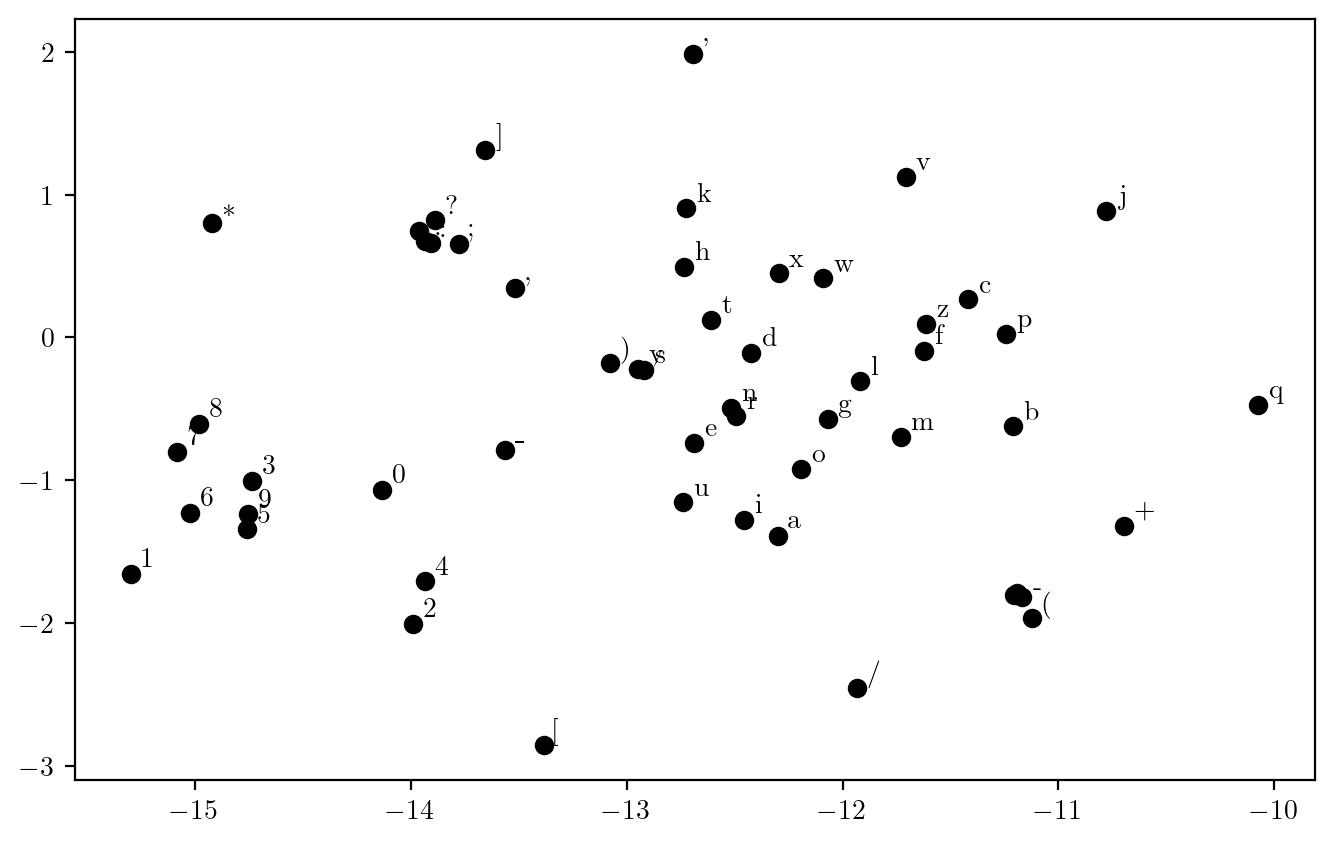

In [23]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [25]:
start = np.random.randint(0, len(new_gulliver) - block_size - 1)
end = start + 100
while new_gulliver[start] != " ":
  start += 1

while new_gulliver[end] != " ":
  end -= 1

seed_text = new_gulliver[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
and his officers were in much pain,
especially when they saw me take out my penknife: but i


===============Predicted Text===============
and his officers were in much pain,
especially when they saw me take out my penknife: but in it secrivate our down of must
not ender destrible his write. i had helest delivere or the moats he majesty to the modink arance in preasel the cupvaiady little silfood at do dif me, it is request; with the
tires, as to in at himanced of was fathest
to the doors the we bell it weight them into to their they they were oeft the
more nears the box in cardh rey houses too compartary the whase it was, and someting of
the the tative to coltriunfisarve where to
the out of giving, former to look farth a deperies in contentions: the circuter that off contrar lice of tamtads, beid strequir plays and recence, pursue the tambled despined to colianlowed then his bleting as in long eind aie time of it other; he she pade expresse